# Reduced Entanglement Ternary Tree

This notebook shows how to generate a reduced-entanglement ternary tree, with a method similar to that of 10.1103/PRXQuantum.5.030333

The MI matrix used later was derived by a different method than the p-GUCCSD in the original paper, namely from a tensor network.

We'll start with a full pairwise Mutual Information matrix for the 7 spatial orbitals of water in sto-3g.

In [1]:
import numpy as np
water_mi = np.array([[ 0.        ,  0.11687544,  0.07579407,  0.54274231,  0.59965614,
         0.13984087,  0.1208934 ],
       [ 0.11687544,  0.        , -0.27575379,  0.44636705,  0.49251647,
         0.04925079,  0.06179358],
       [ 0.07579407, -0.27575379,  0.        ,  0.39213452,  0.64683832,
         0.03424038,  0.4157573 ],
       [ 0.54274231,  0.44636705,  0.39213452,  0.        ,  0.8947678 ,
         0.47164455,  0.44469482],
       [ 0.59965614,  0.49251647,  0.64683832,  0.8947678 ,  0.        ,
         0.49754887,  0.48494587],
       [ 0.13984087,  0.04925079,  0.03424038,  0.47164455,  0.49754887,
         0.        ,  0.0067195 ],
       [ 0.1208934 ,  0.06179358,  0.4157573 ,  0.44469482,  0.48494587,
         0.0067195 ,  0.        ]])

We can plot this to get a better understanding of what's going on.

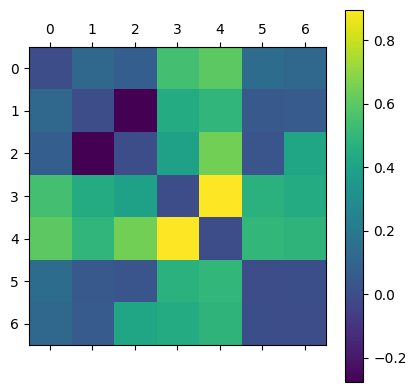

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.matshow(water_mi)
plt.colorbar()

So it looks like spatial orbitals 3 and 4 generally have high mutual information with others. This is good (!) as these orbitals sit at the fermi-level.

In particular we see that spatial orbitals 3 and 4 are highly correlated with eachother, so to produce a reduced entanglement tree, we expect that spin orbitals $3 \to (6,7)$ and $4 \to (8,9)$ should be put in a parity (x) branch together.

Let's create a rett, allowing only 1 X-branch.

In [3]:
from ferrmion.optimize.rett import reduced_entanglement_tree

rett = reduced_entanglement_tree(mutual_information=water_mi, max_branches=1)

To see what nodes exist, and what modes and qubit are mapped to them, we can check the tree's enumeration scheme.

In [4]:
rett.enumeration_scheme

{'': (6, 6),
 'x': (7, 7),
 'xx': (8, 8),
 'xxx': (9, 9),
 'z': (0, 0),
 'zz': (1, 1),
 'zzz': (2, 2),
 'zzzz': (3, 3),
 'zzzzz': (4, 4),
 'zzzzzz': (5, 5),
 'zzzzzzz': (10, 10),
 'zzzzzzzz': (11, 11),
 'zzzzzzzzz': (12, 12),
 'zzzzzzzzzz': (13, 13)}

This actually show's what we wanted, but it's clearer with a visualisation.

First let's just see the structure of the tree...

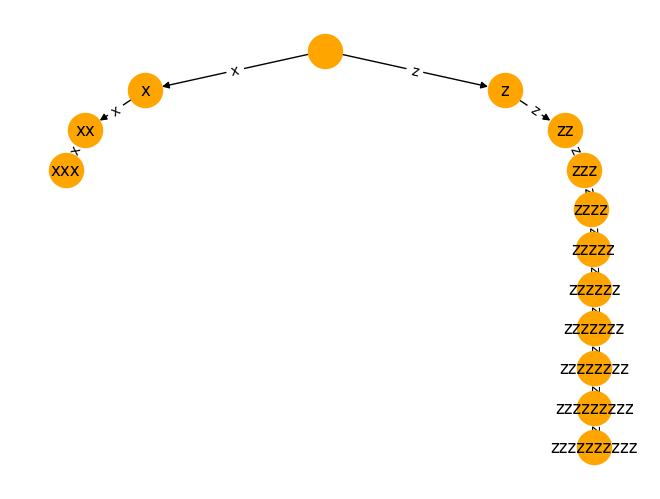

In [5]:
from ferrmion.visualise import draw_tt
draw_tt(rett)

Finally, we label the tree drawing with the tree's enumeration scheme.

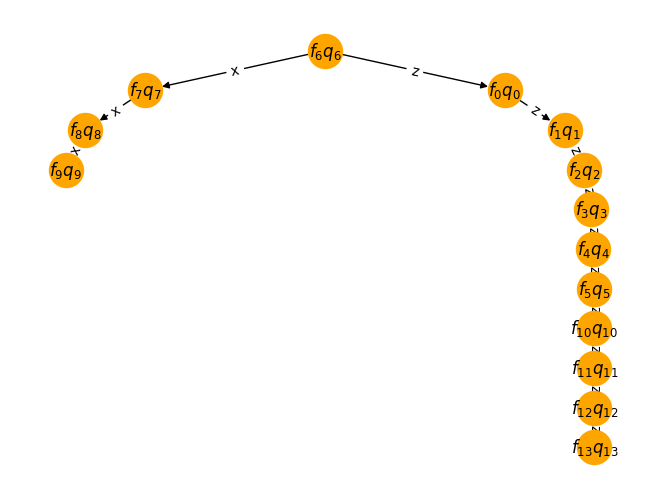

In [6]:
draw_tt(rett, enumeration_scheme=rett.enumeration_scheme)

As expected, the spin-orbitals (fermionic modes) {6,7,8,9} now live on an X-branch together, with the other orbitals on a Z-branch.

We can additionaly use an evolutionary algorithm to optimize the enumeration scheme.

In the original paper, they minimise a cost function which weights the MI by the distance squared.

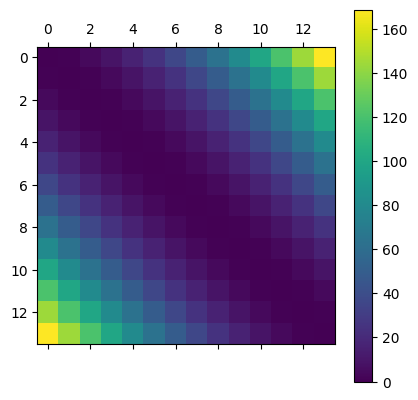

In [7]:
n_mode = rett.n_modes

distance_matrix = np.array(
        [[np.abs(i - j) ** 2 for j in range(n_mode)] for i in range(n_mode)]
    )

plt.matshow(distance_matrix)
plt.colorbar()

This cost function is available in `ferrmion.optimize`.

We need to provide the MI matrix, and a permutation of spatial orbital indices.

Note because we're using a spinless MI matrix, we only need half the number of indices.

In [8]:
from ferrmion.optimize import distance_squared, minimise_mi_distance

naive_permutation = [i for i in range(rett.n_modes//2)]

distance_squared(water_mi, naive_permutation)

[np.float64(100.38009786)]

To find an approximately optimal permutation, we can use the lambda+mu evolutionary algorithm.

In [ ]:
best_permutation = minimise_mi_distance(water_mi, pop_size=1000, ngen=50, pair_spins=False)
print(best_permutation)

[1 5 0 3 4 6 2]


Now let's compare the naive enumeration scheme to the optimized one:

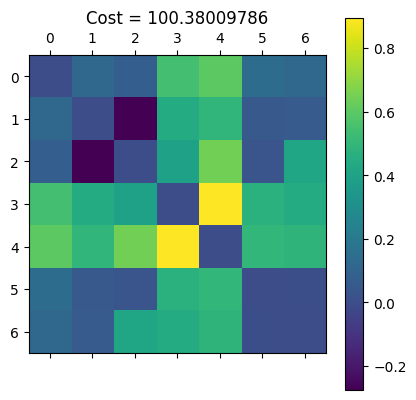

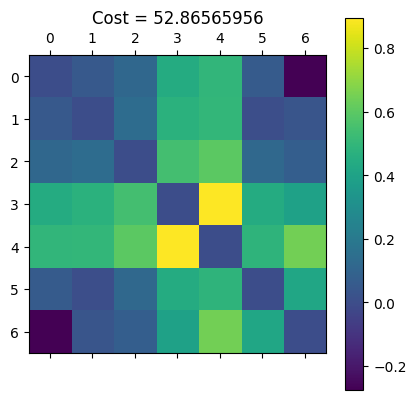

In [10]:
plt.matshow(water_mi)
plt.title(f"Cost = {distance_squared(water_mi, naive_permutation)[0]}")
plt.colorbar()

plt.matshow(water_mi[best_permutation][:,best_permutation])
plt.title(f"Cost = {distance_squared(water_mi, best_permutation)[0]}")
plt.colorbar()

Create a map from the spatial orbital permutation to spin-orbitals

for each spatial orbital $\Psi$, we need two spin orbitals $\chi^\alpha$ and $\chi^\beta$

$$\Psi_i \to \set{\chi_{2i}^\alpha, \chi_{2i+1}^\beta}$$

In [11]:
# i -> (2i, 2i+1)
pos_map = {int(2*best): 2*i for i, best in enumerate(best_permutation)}
pos_map.update({int(2*best)+1: 2*i+1 for i, best in enumerate(best_permutation)})
enumeration_scheme = {k: (v[0],pos_map[v[1]]) for k,v in rett.enumeration_scheme.items()}


We can now redraw the tree with its new enumeration scheme.

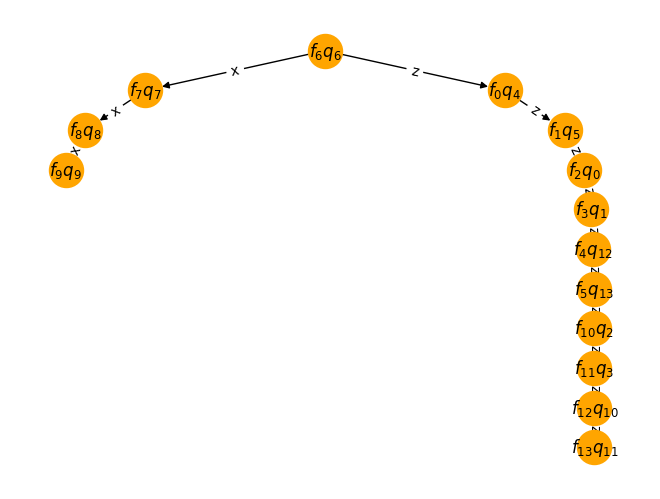

In [12]:
rett.enumeration_scheme = enumeration_scheme
draw_tt(rett, enumeration_scheme=enumeration_scheme)